# Tutorial: supervision with ordinal labels

In [1]:
#pip install pacmap KDEpy

In [2]:
import numpy as np
import scanpy as sc
import pacmap
import stream2 as st2
from sklearn.neighbors import NearestNeighbors

/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data
We directly load preprocessed data from Schiebinger 2019 subsampled to ~10% of points with geosketch

Uncomment the cell below if you wish to replicate preprocessing yourself

In [3]:
adata = sc.read('../data/reprogramming/wot.h5ad')

In [4]:
## download data from https://broadinstitute.github.io/wot/tutorial/
#import wot
#import pandas as pd

#PATH = '../../git/wot/notebooks/data/'
#
##---Path to input files
#FLE_COORDS_PATH ='data/fle_coords.txt'
#FULL_DS_PATH = 'data/ExprMatrix.h5ad'
#VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
#CELL_DAYS_PATH = 'data/cell_days.txt'
#GENE_SETS_PATH = 'data/gene_sets.gmx'
#GENE_SET_SCORES_PATH = 'data/gene_set_scores.csv'
#CELL_SETS_PATH = 'data/cell_sets.gmt'
#MAJOR_CELL_SETS_PATH = 'data/major_cell_sets.gmt'
#SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'
#CELL_GROWTH_PATH = 'data/growth_gs_init.txt'
#
#coord_df = pd.read_csv(PATH+FLE_COORDS_PATH, index_col='id', sep='\t')
#days_df = pd.read_csv(PATH+CELL_DAYS_PATH, index_col='id', sep='\t')
#gene_set_df = pd.read_csv(PATH+GENE_SET_SCORES_PATH, index_col='id').rename(columns={'Trophoblast':'Trophoblast.identity'})
#cell_sets = wot.io.read_sets(PATH+CELL_SETS_PATH)
#serum_id = pd.read_csv(PATH+SERUM_CELL_IDS_PATH,header=None)
#adata = sc.read_h5ad(PATH+VAR_DS_PATH)
#
## subset labeled days
#adata.obs['label']=days_df
#adata=adata[~adata.obs['label'].isna()].copy()
#sc.pp.pca(adata)
#
## add annotations
#df=cell_sets.to_df()
#df['cell_sets'] = ''
#for c in df.columns[:-1]: 
#    df.loc[df[c]>0,'cell_sets']=c
#adata.obs=adata.obs.join(df)
#adata.obs.loc[adata.obs['cell_sets'].isna(),'cell_sets']='nan'
#adata.obs['cell_sets']=adata.obs['cell_sets'].astype(str)
#
#adata.obs['cell_sets_simple']=adata.obs['cell_sets'].copy()
#adata.obs['cell_sets_simple'][adata.obs['cell_sets'].isin(['Trophoblast','SpongioTropho','ProgenitorTropho','SpiralArteryTrophoGiant'])] = 'Trophoblast'
#adata.obs['cell_sets_simple'][adata.obs['cell_sets'].isin(['Neural','RadialGlia','Neuron','Astrocyte'])] = 'Neural'  
#adata.uns['cell_sets_simple_color'] = {
# 'Epithelial': '#EC8E26',
# 'IPS': '#c0c1c0',
# 'MET': '#9e50c7',
# 'Neural': '#47e026',
# 'OPC': '#7f7f7f',
# 'Stromal': '#3f4af4',
# 'Trophoblast': '#b5361a',
# 'nan': '#434342'}
#
#adata.obs['serum']='0'
#adata.obs['serum'][adata.obs.index.isin(serum_id[0].values)]='1'
#
#from geosketch import gs
#sketch_index = gs(adata.obsm['X_pca'], N=25000, replace=False,seed=0)
#s_adata = adata[sketch_index]
#s_adata.write('../data/wot.h5ad')

### compute cytotrace scores using pyrovelocity implementation
#import sys
#sys.path.append('../../pyrovelocity/pyrovelocity/')
#import cytotrace
#import sklearn
#
#PATH = '../../wot/notebooks/data/'
#FULL_DS_PATH = 'data/ExprMatrix.h5ad'
#adata_full = sc.read_h5ad(PATH+FULL_DS_PATH)
#s_adata = sc.read('../data/reprogramming/wot.h5ad')
#s_adata_full = adata_full[s_adata.obs_names].copy()
#ss_adata_full = sc.pp.subsample(s_adata_full,n_obs=5000,copy=True)
#cyto = cytotrace.cytotrace(ss_adata_full,layer=None)
#
#knnreg = sklearn.neighbors.KNeighborsRegressor(weights='distance').fit(ss_adata_full.X,cyto['CytoTRACE'])
#s_adata.obs['CytoTRACE'] = knnreg.predict(s_adata_full.X)

# Supervised dimension reduction

In this dataset cells are already quite well ordered by time. Still there are discrepancies where earlier cells are sampled near the tip of the distribution, after cells from later days and vice versa

If needed we can correct the few outlier ordinal labels by voting

In [5]:
k = 30

knn_label_vote = adata.obs['label'].copy()
dis, idx = NearestNeighbors(n_neighbors=k,n_jobs=30).fit(adata.obsm['X_pca']).kneighbors()

for i, x in enumerate(np.array(adata.obs['label'])[idx]):
    unique, count = np.unique(x, return_counts=1)
    argmax = np.argmax(count)
    if count[argmax] > k/2: 
        knn_label_vote[i] = unique[argmax]
        
adata.obs['knn_label_vote'] = knn_label_vote

We perform unsupervised dimensionality reduction as baseline

/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


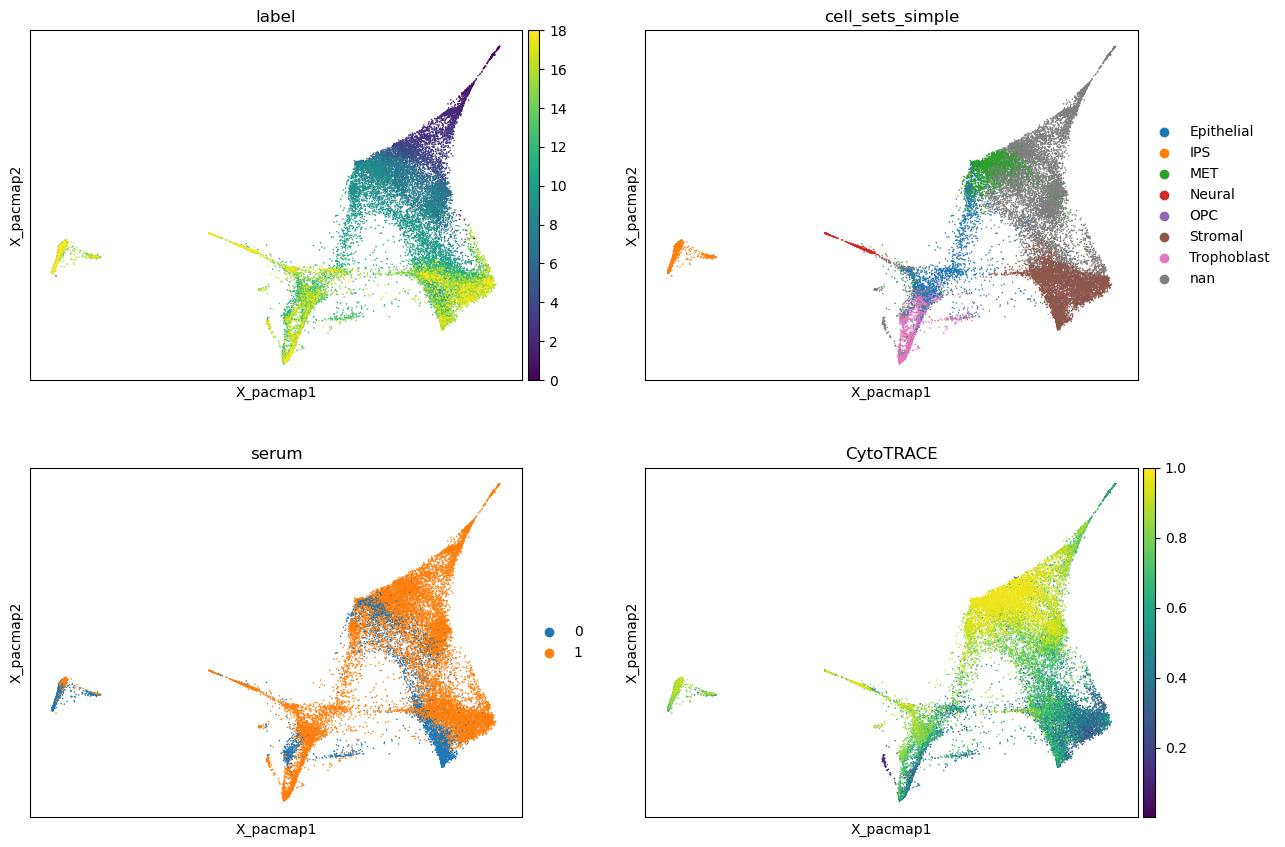

In [6]:
if "X_pacmap" not in adata.obsm:
    adata.obsm['X_pacmap'] = pacmap.PaCMAP(n_neighbors=k, distance='angular',random_state=0, FP_ratio=.4).fit_transform(adata.obsm['X_pca'])
sc.pl.embedding(adata,basis='X_pacmap',color=['label','cell_sets_simple','serum','CytoTRACE'],ncols=2)

There is usually a decision to be made which notion of time we care more about respecting: pseudotime (e.g., following data density or the number of expressed genes) vs wall time. Heuristic tools such as CytoTRACE (https://cytotrace.stanford.edu/) and psupertime (https://github.com/wmacnair/psupertime) can help to define pseudotime and find a consensus with wall time labels. 

In case we decide to more closely follow wall time, a simple solution is to perform supervised dimensionality reduction by using ordinal labels and choosing a supervision strength.

/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


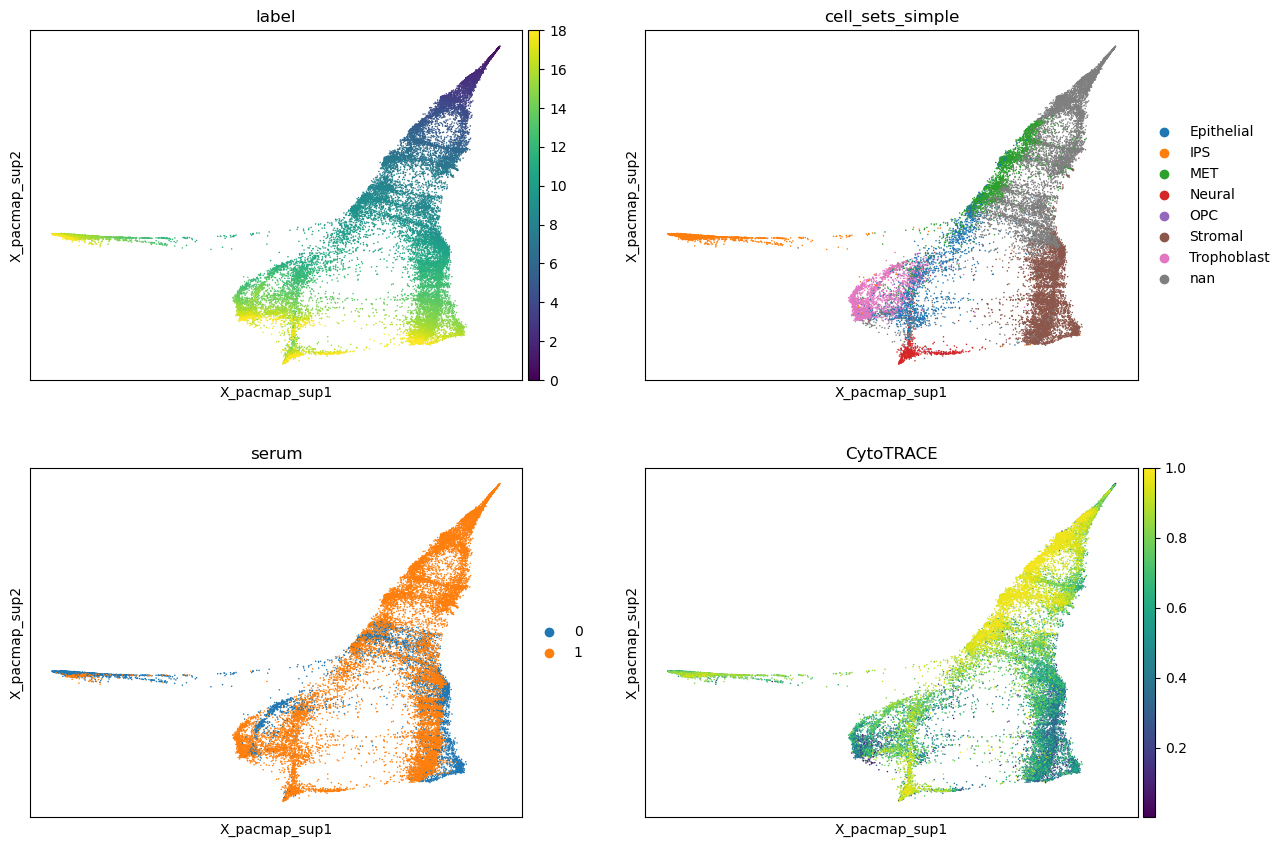

In [7]:
if "X_pacmap_sup" not in adata.obsm:
    knn_dists,knn_idx = st2.tl.ordinal_knn(adata,obsm='X_pca',ordinal_label='label', method='force',
                                              n_neighbors = k, n_natural = 2, metric = 'cosine')


    scaled_dist = np.ones_like(knn_idx,dtype='float32')
    pair_neighbors = pacmap.sample_neighbors_pair(adata.obsm['X_pca'], scaled_dist, knn_idx, k)
    adata.obsm['X_pacmap_sup'] = pacmap.PaCMAP(n_neighbors=k,random_state=0,FP_ratio=.4,
                                               pair_neighbors=pair_neighbors).fit_transform(adata.obsm['X_pca'])
sc.pl.embedding(adata,basis='X_pacmap_sup',color=['label','cell_sets_simple','serum','CytoTRACE'],ncols=2)

# Trajectory inference
Let us seed the graph with a minimum spanning tree. 
We can see that 10 clusters are not enough

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


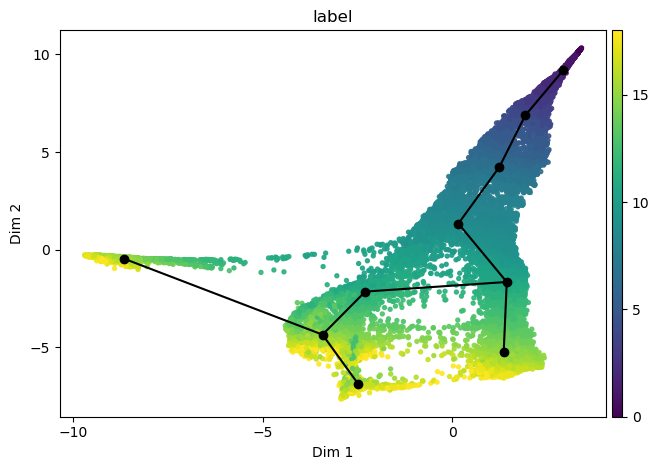

In [8]:
adata.obsm['X_dr']=adata.obsm['X_pacmap_sup']
st2.tl.seed_graph(adata,n_clusters=10,use_weights=False)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

A simple solution is to increase the number of clusters

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


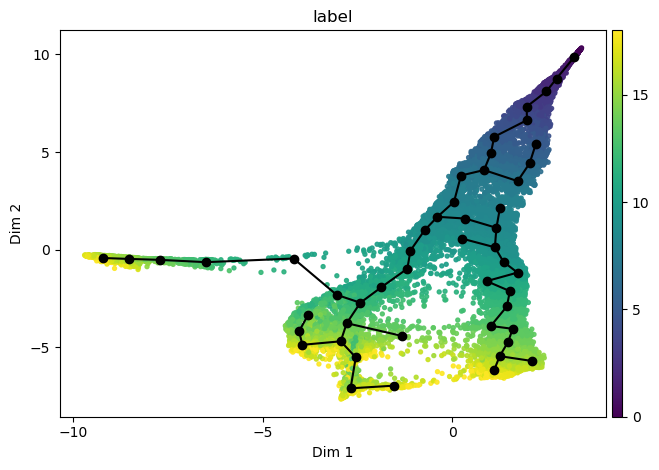

In [9]:
st2.tl.seed_graph(adata,n_clusters=50,use_weights=False)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

The seed graph is still not ideal, e.g. for IPS cells because the start of the branch
is very sparse.

This can be improved by computing density and assigning higher weights to points in sparse regions of data

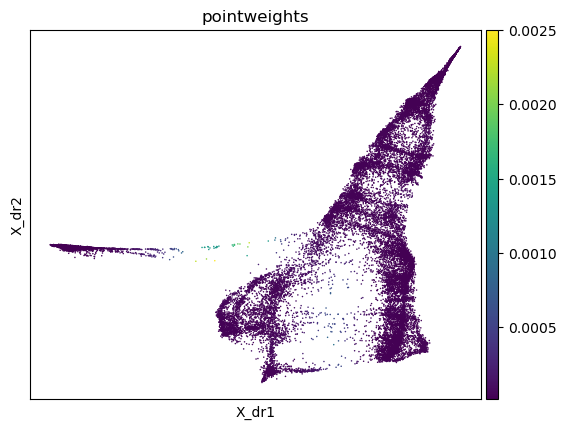

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


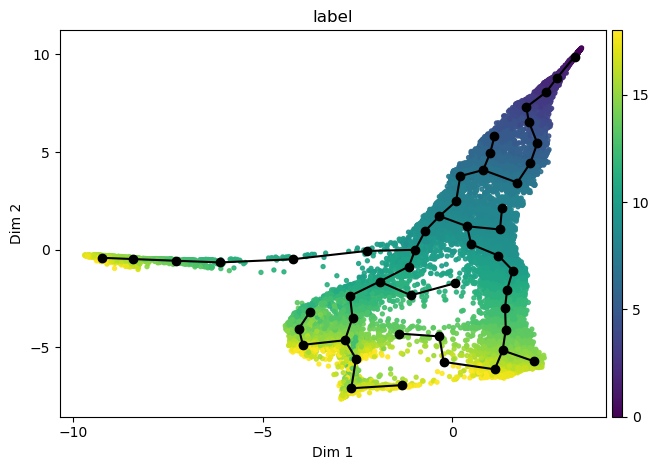

In [10]:
st2.tl.get_weights(adata,bandwidth=.5,method='fft')
sc.pl.embedding(adata,basis='X_dr',color='pointweights')

st2.tl.seed_graph(adata,n_clusters=50,use_weights=True)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

We now refine the guess by computing an unsupervised principal graph

We can make use of GPU acceleration with the cupy library; if you  don't have one set `GPU=False`

Constructing tree 1 of 1 / Subset 1 of 1
Computing EPG with  100  nodes on  25000  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

7||51	0.5845	51	50	35	7	0	0	0.2413	0.1981	0.9929	0.9942	0.3223	0.0209	1.0646	54.2967	0
6||52	0.5565	52	51	38	6	0	0	0.2393	0.2003	0.993	0.9941	0.3046	0.0126	0.6562	34.1227	0
5||53	0.5748	53	52	41	5	0	0	0.2501	0.2122	0.9926	0.9938	0.2948	0.03	1.5889	84.2119	0
5||54	0.5485	54	53	42	5	0	0	0.2411	0.2068	0.9929	0.9939	0.2818	0.0256	1.3806	74.5519	0
5||55	0.5387	55	54	43	5	0	0	0.2448	0.2126	0.9928	0.9937	0.2679	0.026	1.4299	78.645	0
4||56	0.5281	56	55	46	4	0	0	0.246	0.2147	0.9928	0.9937	0.2572	0.0249	1.3928	77.9941	0
4||57	0.5168	57	56	47	4	0	0	0.2442	0.2143	0.9928	0.9937	0.2507	0.0219	1.2484	71.1609	0
3||58	0.5154	58	57	50	3	0	0	0.2402	0.2102	0.9929	0.9938	0.2513	0.0239	1.3834	80.2387	0
3||59	0.5107	59	58	51	3	0	0	0.2426	0.214	0.9929	0.9937	0.244	0.0242	1.4257	84.1157	0
3||60	0.5007	60	59	52

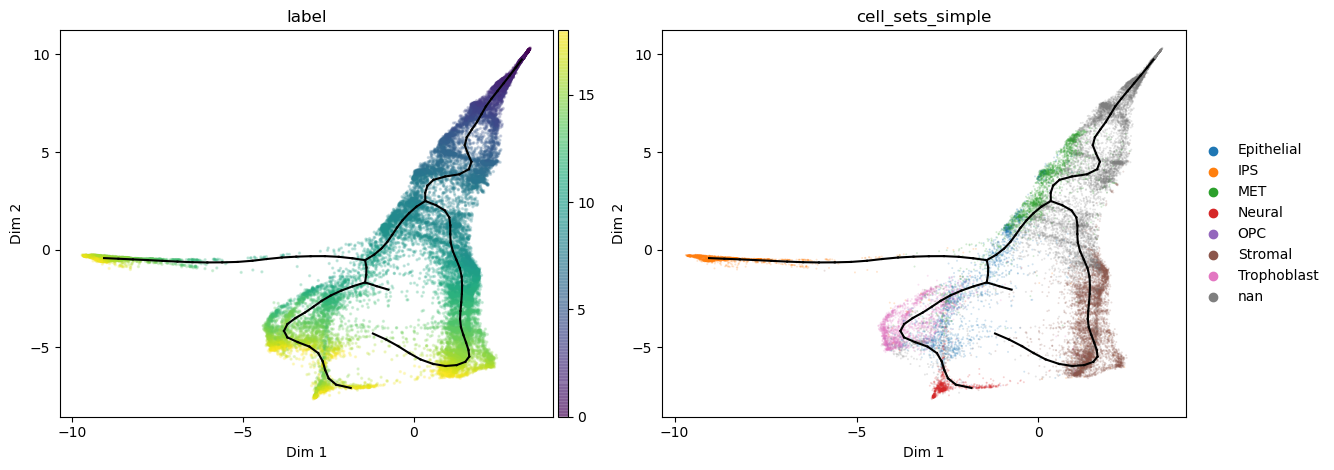

In [12]:
st2.tl.learn_graph(adata,n_nodes=100,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.01,
                   use_weights=True, GPU=True, store_evolution=True,
                   max_candidates={'AddNode2Node': 15, 'BisectEdge': 10, 'ShrinkEdge':10},
                   verbose=1,)
st2.pl.graph(adata,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2)

Since we used `store_evolution=True` we have access to graphs for any number of nodes between
n_clusters of the seed graph and n_nodes

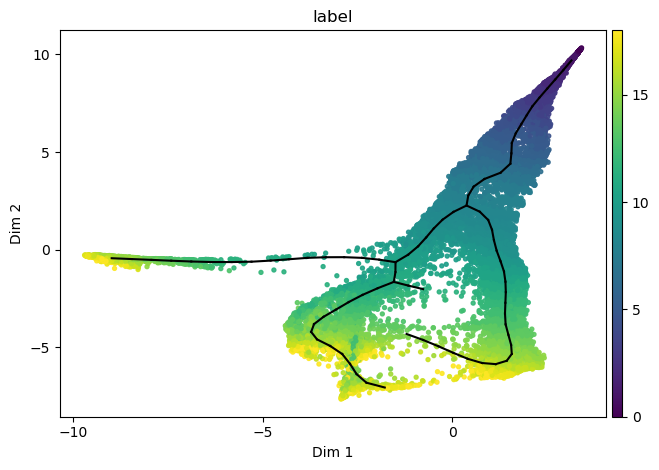

In [13]:
st2.tl.use_graph_with_n_nodes(adata,n_nodes=80)
st2.pl.graph(adata,key='epg',color=['label'])

While the structure is better than the seed graph, the result is suboptimal and some branches do not follow ordinal labels.
<br>
We can compute a supervised principal graph to get better results
<br>
<br>
Ordinal labels should be smoothed into a continuous variable before learning the supervised graph <br>
(here they are already quite smooth so we won't need this - we just discretize them into 3 bins as an example)

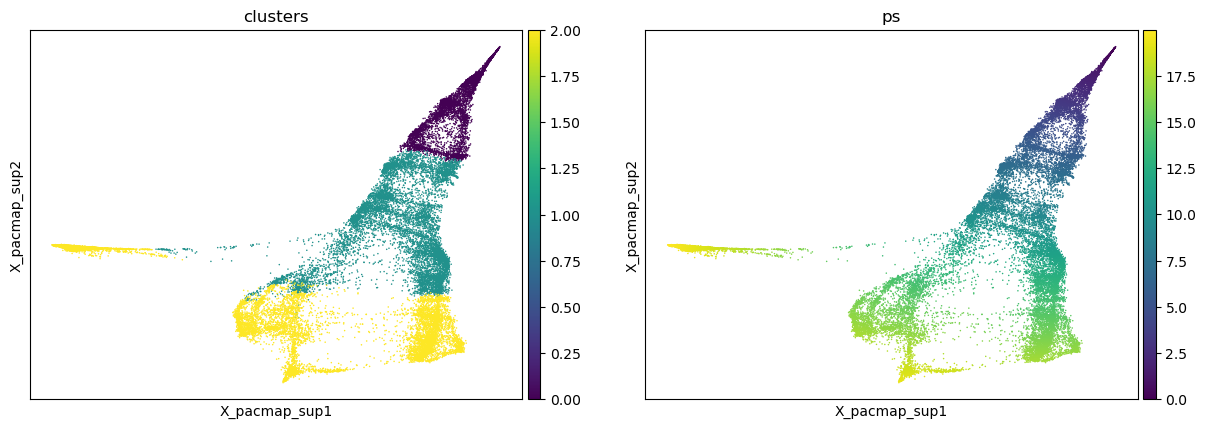

In [14]:
#define a root point
root_idx = 0
time = adata.obs['label']
bins = np.histogram(time, bins=3)[1]
adata.obs['clusters'] = np.digitize(time, bins[1:], right=True)

st2.tl.smooth_ordinal_labels(adata, root_idx, ordinal_label='clusters', obsm="X_pacmap_sup")
sc.pl.embedding(adata,'X_pacmap_sup',color=['clusters','ps'])

We then need to define 3 extra variables: root cell, ordinal labels to follow and supervision strength
- ordinal_supervision_strength = 1 means equal importance to respecting ordinal labels vs natural data order,
- ordinal_supervision_strength = 10 means ordinal labels order is 10 times more important 

Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  100  nodes on  25000  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

6||52	0.5399	52	51	38	6	0	0	0.2372	0.1969	0.993	0.9942	0.2922	0.0105	0.5463	28.4089	0
6||53	0.5101	53	52	39	6	0	0	0.2192	0.1814	0.9935	0.9947	0.2812	0.0097	0.5153	27.3126	0
5||54	0.4987	54	53	42	5	0	0	0.2145	0.1766	0.9937	0.9948	0.2735	0.0107	0.5777	31.1957	0
5||55	0.4846	55	54	43	5	0	0	0.2083	0.1728	0.9939	0.9949	0.2663	0.01	0.5492	30.2048	0
5||56	0.4768	56	55	44	5	0	0	0.2086	0.1752	0.9939	0.9948	0.2578	0.0105	0.5854	32.7803	0
4||57	0.4747	57	56	47	4	0	0	0.2199	0.1873	0.9935	0.9945	0.2465	0.0082	0.4667	26.5997	0
4||58	0.4691	58	57	48	4	0	0	0.2143	0.1813	0.9937	0.9947	0.2474	0.0075	0.4364	25.3112	0
4||59	0.4658	59	58	49	4	0	0	0.2121	0.1794	0.9938	0.9947	0.246	0.0078	0.4583	27.0391	0
4||60	0.4576	60	59	50	4	0	0	0.214	0

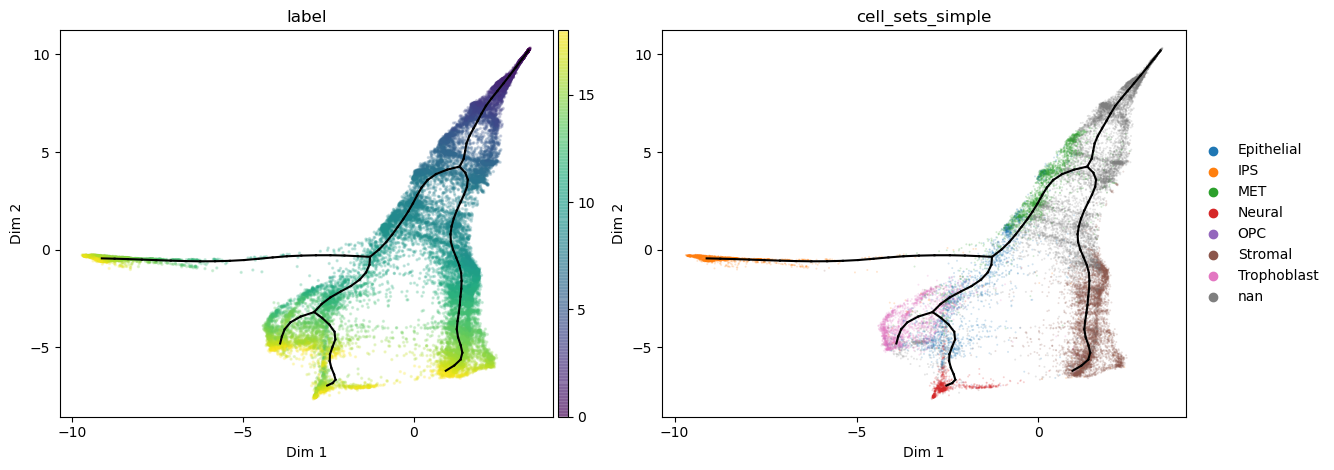

In [15]:
adata2=adata.copy()
st2.tl.learn_graph(
    adata2,
    n_nodes=100,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.01,
    GPU=True,store_evolution=True,use_weights=True,use_seed=True,
    max_candidates={'AddNode2Node': 15, 'BisectEdge': 10, 'ShrinkEdge':10},verbose=1,
                   
    # supervision parameters
    ordinal_label = 'knn_label_vote',                            #define the ordinal vector to follow
    ordinal_root_point = root_idx,                               #define a root point (e.g., cell with lowest ordinal value)
    ordinal_supervision_strength = 1,                            #define strength of supervision in [0, +inf).
)

st2.pl.graph(adata2,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2)

# Pseudotime and trajectory plots

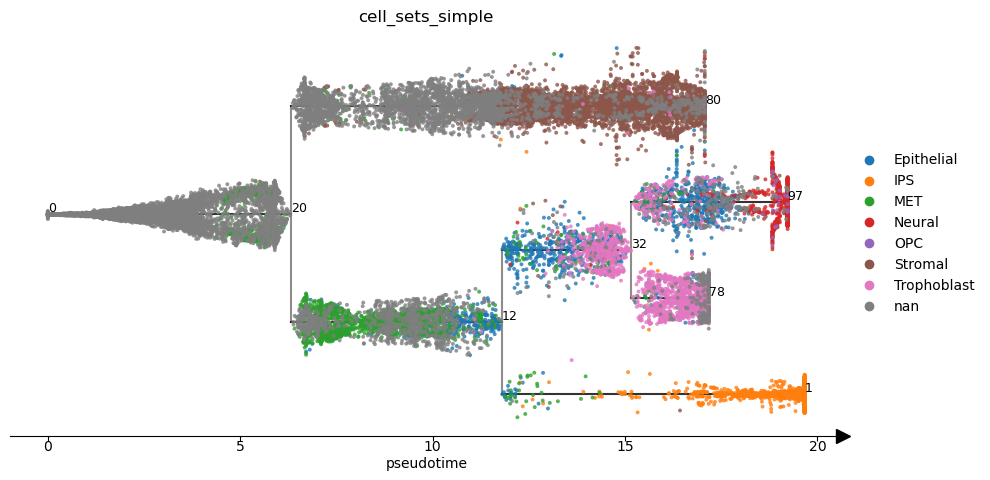

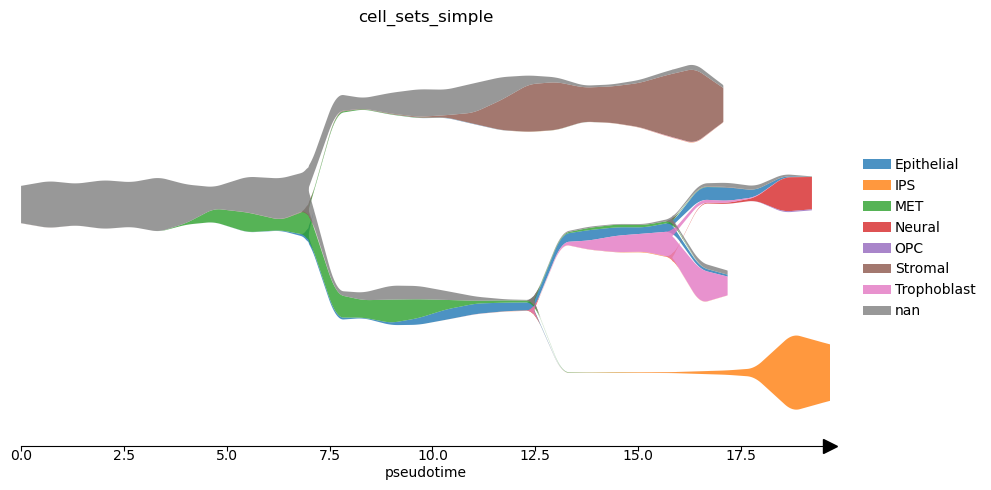

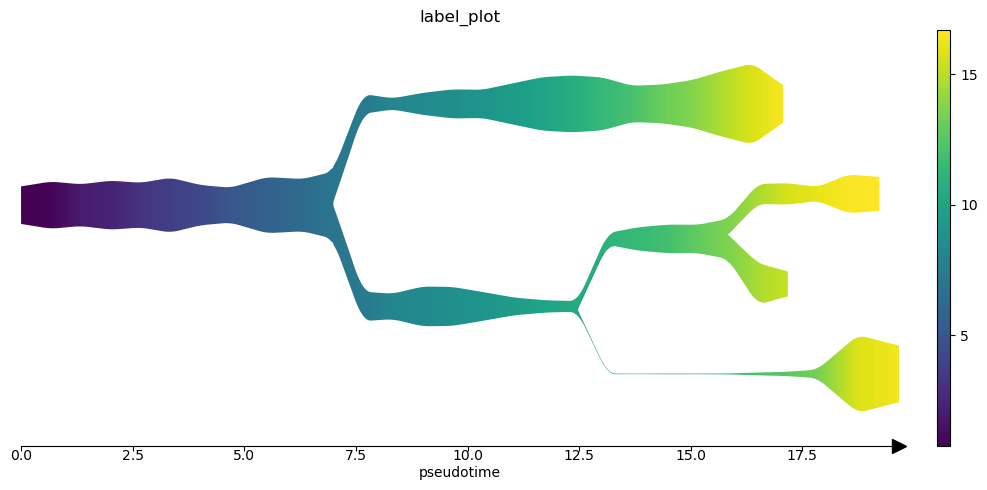

In [16]:
st2.tl.infer_pseudotime(adata2,0)
#jitter to prevent bug for equal pseudotime values
adata2.obs['label_plot']=adata2.obs['label']+1e-20*np.random.random(len(adata2))

st2.pl.stream_sc(adata2,source=0,preference=[80,97,78,1],dist_scale=.5,color=['cell_sets_simple'],fig_size=(10,5))
st2.pl.stream(adata2,source=0,preference=[80,97,78,1],factor_min_win=1.5,color=['cell_sets_simple'],fig_size=(10,5))
st2.pl.stream(adata2,source=0,preference=[80,97,78,1],factor_min_win=1.5,color=['label_plot'],fig_size=(10,5))

# Save results

In [17]:
#these keys can fail to write
del adata2.uns['epg']['conn']
del adata2.uns['seed_epg']['conn']
del adata2.uns['epg']['graph_evolution']
del adata2.uns['stream_tree']

In [ ]:
adata2.write('../data/test.h5ad')